In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow-io

     |████████████████████████████████| 22.7 MB 4.6 MB/s 
     |████████████████████████████████| 2.1 MB 33.6 MB/s 


In [ ]:
!pip install pydub
!apt-get install ffmpeg


Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
from os import path
from pydub import AudioSegment

def convert_mp3_to_wav(src, dst):
                                                                                
  sound = AudioSegment.from_file(src)
  sound = sound.set_channels(1)
  sound.export(dst, format="wav")

In [ ]:
def mono_to_stereo(src, dst):
  sound = AudioSegment.from_wav(src)
  sound = sound.set_channels(1)
  sound.export("dst", format="wav")

In [ ]:
convert_mp3_to_wav("/content/drive/MyDrive/musicGAN/music_raw/Untitled - 9:10:21, 8.28 PM.mp3", "/content/drive/MyDrive/musicGAN/music/1.wav" )

In [ ]:
MUSIC_PATH = "/content/drive/MyDrive/musicGAN/music"

import tensorflow as tf
import tensorflow_io as tfio

audio = tfio.audio.AudioIOTensor('/content/drive/MyDrive/musicGAN/music/1.wav')

print(audio)

<AudioIOTensor: shape=[1968768       1], dtype=<dtype: 'int16'>, rate=44100>


In [ ]:
audio_slice = audio[:]
# remove last dimension
audio_tensor = tf.squeeze(audio_slice, axis=[-1])
print(audio_tensor)

tf.Tensor([0 0 0 ... 0 0 0], shape=(1968768,), dtype=int16)


In [ ]:
from IPython.display import Audio

Audio(audio_tensor.numpy(), rate=audio.rate.numpy())

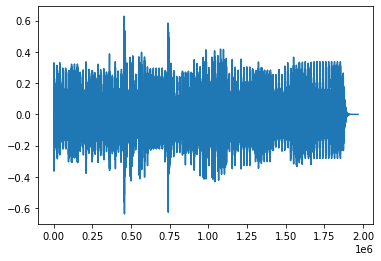

In [ ]:
import matplotlib.pyplot as plt


tensor = tf.cast(audio_tensor, tf.float32) / 32768.0

plt.figure()
plt.plot(tensor.numpy())

In [ ]:
import tensorflow as tf

def generator(z):
    generator = tf.keras.models.Sequential()

    generator.add(tf.layers.Dense(z, use_bias=False, input_shape=1*16*1024))
    generator.add(tf.layers.BatchNormalization())
    generator.add(tf.layers.LeakyReLU())

    generator.add(tf.layers.Reshape((None, 16, 1024)))
    assert generator.output_shape == (None, 16, 1024)

    # generator.add(layers.Conv1DTranspose(filters=256, kernel_size=25, padding='same', use_bias=False))
    # assert generator.output_shape == (None, 16, 1024)
    # generator.add(layers.BatchNormalization())
    # generator.add(layers.LeakyReLU())

    generator.add(tf.layers.Conv2DTranspose(filters=512, kernel_size=25, strides=4, padding='same', use_bias=False))
    assert generator.output_shape == (None, 64, 512)
    generator.add(tf.layers.BatchNormalization())
    generator.add(tf.layers.LeakyReLU())

    generator.add(tf.layers.Conv2DTranspose(filters=256, kernel_size=25, strides=4, padding='same', use_bias=False))
    assert generator.output_shape == (None, 256, 256)
    generator.add(tf.layers.BatchNormalization())
    generator.add(tf.layers.LeakyReLU())

    generator.add(tf.layers.Conv2DTranspose(filters=128, kernel_size=25, strides=4, padding='same', use_bias=False))
    assert generator.output_shape == (None, 1024, 128)
    generator.add(tf.layers.BatchNormalization())
    generator.add(tf.layers.LeakyReLU())

    generator.add(tf.layers.Conv2DTranspose(filters=64, kernel_size=25, strides=4, padding='same', use_bias=False))
    assert generator.output_shape == (None, 4096, 4)
    generator.add(tf.layers.BatchNormalization())
    generator.add(tf.layers.LeakyReLU())

    generator.add(tf.layers.Conv1DTranspose(filters=32, kernel_size=25, strides=4, padding='same', use_bias=False))
    assert generator.output_shape == (None, 16, 16, 64)
    generator.add(tf.layers.BatchNormalization())
    generator.add(tf.layers.LeakyReLU())

    generator.add(tf.layers.Conv2DTranspose(filters=16, kernel_size=25, strides=4, padding='same', use_bias=False, activation='tanh'))
    assert generator.output_shape == (None, 16384, 1)
    
    return generator

In [ ]:
def discriminator():
    discriminator = tf.keras.models.Sequential()

    discriminator.add(tf.layers.Conv2D(filters=64, kernel_size=25, strides=4, padding='same', input_shape=[16384, 1]))
    discriminator.add(tf.layers.LeakyReLU())
    discriminator.add(tf.layers.Dropout(0.3))

    discriminator.add(tf.layers.Conv2D(filters=128, kernel_size=25, strides=4, padding='same'))
    discriminator.add(tf.layers.LeakyReLU())
    discriminator.add(tf.layers.Dropout(0.3))

    discriminator.add(tf.layers.Conv2D(filters=256, kernel_size=25, strides=4, padding='same'))
    discriminator.add(tf.layers.LeakyReLU())
    discriminator.add(tf.layers.Dropout(0.3))

    discriminator.add(tf.layers.Conv2D(filters=512, kernel_size=25, strides=4, padding='same'))
    discriminator.add(tf.layers.LeakyReLU())
    discriminator.add(tf.layers.Dropout(0.3))

    discriminator.add(tf.layers.Conv2D(filters=1024, kernel_size=25, strides=4, padding='same'))
    discriminator.add(tf.layers.LeakyReLU())
    discriminator.add(tf.layers.Dropout(0.3))


    discriminator.add(tf.layers.Flatten())

    discriminator.add(tf.layers.Dense(1))

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(fake):
    return loss(tf.ones_like(fake), fake)

In [ ]:
def discriminator_loss(real, fake):
    real_loss = loss(tf.ones_like(real), real)
    fake_loss = loss(tf.zeros_like(fake), fake)
    return real_loss + fake_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
@tf.function
def train_step(sound):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)
        
        real = discriminator(sound, training=True)
        fake = discriminator(generated, training=True)
        
        gen_loss = generator_loss(fake)
        disc_loss = discriminator_loss(real, fake)
        
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))